# Flight Prediction EDA

### 0. Data Loading & Preprocessing

In [26]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, BooleanType, TimestampType, DateType

from pyspark.sql import functions as F

from pyspark.sql.functions import col, avg, to_timestamp, when, count, hour, sum, desc, row_number, date_format, month, dayofmonth
from pyspark.sql.functions import month, year, dayofweek, dayofweek, to_date, datediff
from pyspark.sql.functions import concat, lit
from pyspark.ml.feature import StringIndexer

from pyspark.sql.window import Window

from datetime import datetime

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
spark = SparkSession.builder.appName('FlightDelay').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([
    ('spark.executor.memory', '16g'),  
    ('spark.executor.cores', '4'),    
    ('spark.cores.max', '32'),        
    ('spark.driver.memory', '16g')     
])

#print spark configuration settings
spark.sparkContext.getConf().getAll()

:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-0661cde4-a9b5-4086-9944-685678e0e863;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;4.4.0 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.16.0 in central
	found com.google.guava#guava;31.1-jre in centra

[('spark.stage.maxConsecutiveAttempts', '10'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.eventLog.enabled', 'true'),
 ('spark.submit.pyFiles',
  '/root/.ivy2/jars/com.johnsnowlabs.nlp_spark-nlp_2.12-4.4.0.jar,/root/.ivy2/jars/graphframes_graphframes-0.8.2-spark3.1-s_2.12.jar,/root/.ivy2/jars/com.typesafe_config-1.4.2.jar,/root/.ivy2/jars/org.rocksdb_rocksdbjni-6.29.5.jar,/root/.ivy2/jars/com.amazonaws_aws-java-sdk-bundle-1.11.828.jar,/root/.ivy2/jars/com.github.universal-automata_liblevenshtein-3.0.0.jar,/root/.ivy2/jars/com.google.cloud_google-cloud-storage-2.16.0.jar,/root/.ivy2/jars/com.navigamez_greex-1.0.jar,/root/.ivy2/jars/com.johnsnowlabs.nlp_tensorflow-cpu_2.12-0.4.4.jar,/root/.ivy2/jars/it.unimi.dsi_fastutil-7.0.12.jar,/root/.ivy2/jars/org.projectlombok_lombok-1.16.8.jar,/root/.ivy2/jars/com.google.guava_guava-31.1-jre.jar,/root/.ivy2/jars/com.google.guava_failureaccess-1.0.1.jar,/root/.ivy2/jars/com.google.guava_listenablefuture-9999.0-empty-to-avoid-conflict-

In [3]:
schema = StructType([
    StructField("FlightDate", DateType(), True),
    StructField("Airline", StringType(), True),
    StructField("Origin", StringType(), True),
    StructField("Dest", StringType(), True),
    StructField("Cancelled", BooleanType(), True),
    StructField("Diverted", BooleanType(), True),
    StructField("CRSDepTime", TimestampType(), True),
    StructField("DepTime", TimestampType(), True),
    StructField("DepDelayMinutes", DoubleType(), True),
    StructField("ArrTime", TimestampType(), True),
    StructField("ArrDelayMinutes", DoubleType(), True),
    StructField("AirTime", DoubleType(), True),
    StructField("CRSElapsedTime", DoubleType(), True),
    StructField("ActualElapsedTime", DoubleType(), True),
    StructField("Distance", DoubleType(), True),
    StructField("Flight_Number_Operating_Airline", IntegerType(), True),
    StructField("TaxiOut", DoubleType(), True),
    StructField("WheelsOff", TimestampType(), True),
    StructField("WheelsOn", TimestampType(), True),
    StructField("TaxiIn", DoubleType(), True),
    StructField("CRSArrTime", TimestampType(), True),
    StructField("Airline_index", DoubleType(), False),
    StructField("Origin_index", DoubleType(), False),
    StructField("Dest_index", DoubleType(), False),
    StructField("Flight_Number_Operating_Airline_index", DoubleType(), False)
])

bucket_path = "gs://msca-bdp-student-gcs/Group4/encoded_df"
df = spark.read.option("header", "true").schema(schema).csv(bucket_path)

In [4]:
# Inspect the data partitions and repartition if needed
print("Partitions:", df.rdd.getNumPartitions())

Partitions: 184


In [5]:
# Check missing value
#missing_count = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]) \
                  #.rdd.flatMap(lambda x: x).sum()
#if missing_count > 0:
    #print(f"DataFrame contains missing values. Total missing values: {missing_count}")
#else:
    #print("DataFrame has no missing values.")

In [6]:
# Data shape
num_rows = df.count()
num_columns = len(df.columns)
print(num_rows, num_columns)

# View data
df.show(10)
df.printSchema()

76969550 25
+----------+-------+------+----+---------+--------+-------------------+-------------------+---------------+-------------------+---------------+-------+--------------+-----------------+--------+-------------------------------+-------+-------------------+-------------------+------+-------------------+-------------+------------+----------+-------------------------------------+
|FlightDate|Airline|Origin|Dest|Cancelled|Diverted|         CRSDepTime|            DepTime|DepDelayMinutes|            ArrTime|ArrDelayMinutes|AirTime|CRSElapsedTime|ActualElapsedTime|Distance|Flight_Number_Operating_Airline|TaxiOut|          WheelsOff|           WheelsOn|TaxiIn|         CRSArrTime|Airline_index|Origin_index|Dest_index|Flight_Number_Operating_Airline_index|
+----------+-------+------+----+---------+--------+-------------------+-------------------+---------------+-------------------+---------------+-------+--------------+-----------------+--------+-------------------------------+-------+-

In [7]:
# create status column
# we assume a flight is delayed only when it arrives at its destination more than 15 minutes later than its expected arrival time
df = df.withColumn(
    "status",
    when(col("Cancelled") == True, "Cancelled")
    .when(col("Diverted") == True, "Diverted")
    .when(col("ArrDelayMinutes") > 15, "Delayed")
    .otherwise("OnTime")
)

indexer = StringIndexer(inputCol="status", outputCol="status_index")
df = indexer.fit(df).transform(df)

df.show(5)

24/12/02 20:43:46 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+-------+------+----+---------+--------+-------------------+-------------------+---------------+-------------------+---------------+-------+--------------+-----------------+--------+-------------------------------+-------+-------------------+-------------------+------+-------------------+-------------+------------+----------+-------------------------------------+------+------------+
|FlightDate|Airline|Origin|Dest|Cancelled|Diverted|         CRSDepTime|            DepTime|DepDelayMinutes|            ArrTime|ArrDelayMinutes|AirTime|CRSElapsedTime|ActualElapsedTime|Distance|Flight_Number_Operating_Airline|TaxiOut|          WheelsOff|           WheelsOn|TaxiIn|         CRSArrTime|Airline_index|Origin_index|Dest_index|Flight_Number_Operating_Airline_index|status|status_index|
+----------+-------+------+----+---------+--------+-------------------+-------------------+---------------+-------------------+---------------+-------+--------------+-----------------+--------+-------------

### 1. Flight Status Distribution

#### 1.1 General distribution of status

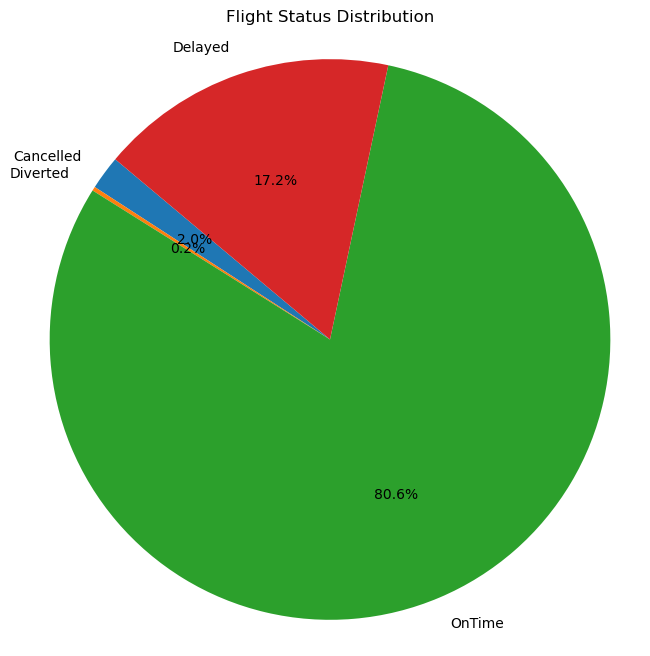

In [44]:
status_counts = df.groupBy("status").count()

# Grouping the data by the 'status' column to get the distribution counts
status_counts= status_counts.toPandas()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(status_counts['count'], labels=status_counts['status'], autopct='%1.1f%%', startangle=140)
plt.title('Flight Status Distribution')
plt.axis('equal') 
plt.show()

#### From this pie chart, 
1. we assumed that most of flights could arrive on time (80%). For the abnormal flight status, nearly 90% was caused by delayed, and the diverted flight status rarely happened.
2. The data imbalance is siginificant: the cancalled and diverted entities didn't exceed 5%, so we would probably choose to exclude them in later the machine learning process.

#### 1.2 Specifc classfication of on-time/delayed

To be more specific, we divided normal/cancelled/diverted flight status into 6 scenarios
1. [Normal]: If both DepDelayMinutes <= 0 and ArrDelayMinutes <= 0
2. [Normal] with departure delay: If DepDelayMinutes > 0 and ArrDelayMinutes <= 0
3. [Delayed]: If DepDelayMinutes > 0 and ArrDelayMinutes > 0
4. [Delayed]: If DepDelayMinutes <= 0 and ArrDelayMinutes > 0
5. [Cancelled]: Based on the Cancelled column
6. [Diverted]: Based on the Diverted column

In [45]:
from pyspark.sql.functions import when, col

df_sp= df.withColumn(
    "status",
    when((col("Cancelled") == True), "Cancelled")
    .when((col("Diverted") == True), "Diverted")
    .when((col("DepDelayMinutes") <= 0) & (col("ArrDelayMinutes") <= 0), "Normal (Not delayed/cancelled normal)")
    .when((col("DepDelayMinutes") > 0) & (col("ArrDelayMinutes") <= 0), "Normal (Departure delay, arrival normal normal)")
    .when((col("DepDelayMinutes") > 0) & (col("ArrDelayMinutes") > 0), "Delay (Departure delay, arrival delay delay)")
    .when((col("DepDelayMinutes") <= 0) & (col("ArrDelayMinutes") > 0), "Delay (Departure normal, arrival delay delay)")
)

In [46]:
status_counts_sp = df_sp.groupBy("status").count()
status_counts_sp=status_counts_sp.filter((col("status")!="Cancelled")&(col("status")!="Diverted"))
status_counts_sp.show()

+--------------------+--------+
|              status|   count|
+--------------------+--------+
|Normal (Departure...| 7495151|
|Normal (Not delay...|40673861|
|Delay (Departure ...|19206483|
|Delay (Departure ...| 7899051|
+--------------------+--------+



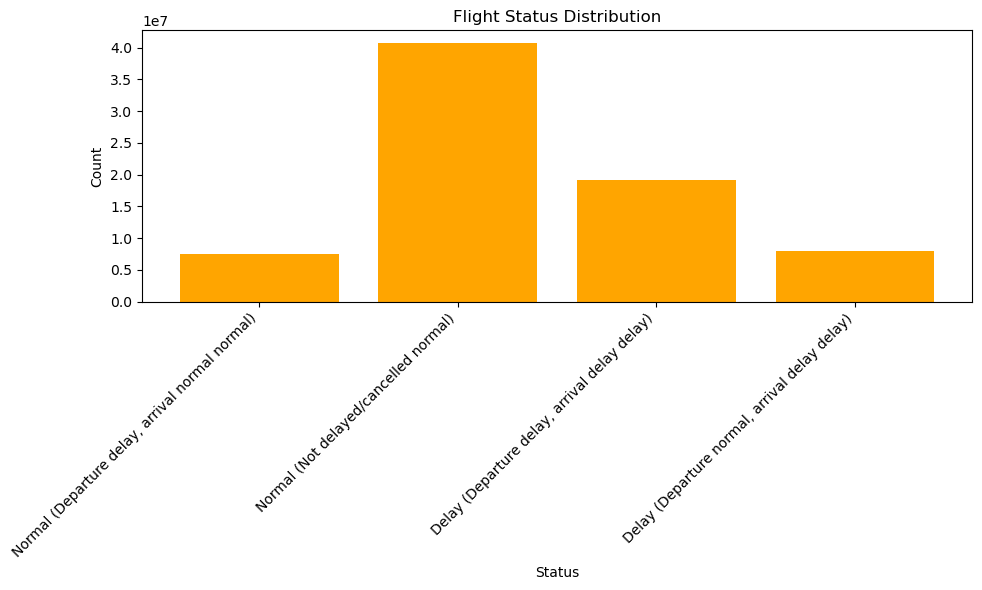

In [47]:
status_counts_sp=status_counts_sp.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(status_counts_sp['status'], status_counts_sp['count'], color='orange')

# Adding titles and labels
plt.title('Flight Status Distribution')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Status')
plt.ylabel('Count')
plt.tight_layout()  # Equal aspect ratio ensures that pie chart is circular.
plt.show()

### 2. Delay/Cancellation Rate Analysis

#### 2.1 Peak hours or times when delays/cancellation are most likely for all flights
*Since we are considering the departing airports, we assume a flight is delayed only when its departure is delayed and its arrival is delay by more than 15 minutes.

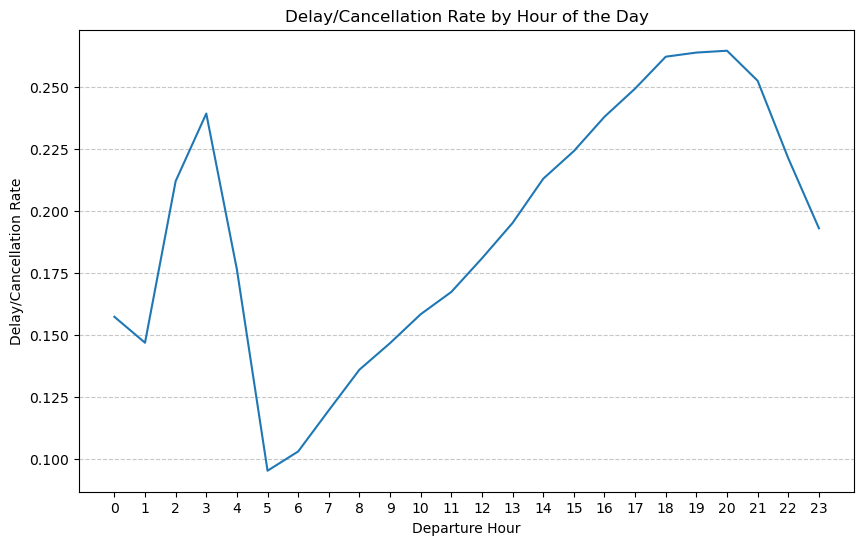

In [10]:
delay_cancellation_pd = delay_cancellation.orderBy("DepHour").toPandas()

# create a bar chart
plt.figure(figsize=(10, 6))
plt.plot(delay_cancellation_pd["DepHour"], delay_cancellation_pd["Probability"] , label="Probability")
plt.xlabel("Departure Hour")
plt.ylabel("Delay/Cancellation Rate")
plt.title("Delay/Cancellation Rate by Hour of the Day")
plt.xticks(delay_cancellation_pd["DepHour"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [9]:
# Extract the hour from the CRSDepTime column (scheduled departure time)
df = df.withColumn("DepHour", hour(col("CRSDepTime")))
df = df.filter(col("DepHour").isNotNull())

# Calculate the total number of delays and cancellations per hour
delay_cancellation = df.groupBy("DepHour").agg(
    count("*").alias("TotalFlights"),
    count(when((col("status") == "Delayed"), 1)).alias("TotalDelays"),
    sum(col("Cancelled").cast("int")).alias("TotalCancellations")
)

delay_cancellation = delay_cancellation.withColumn(
    "Probability", (col("TotalDelays") + col("TotalCancellations")) / col("TotalFlights")
)

peak_hours = delay_cancellation.orderBy(col("Probability").desc())
peak_hours.show()

+-------+------------+-----------+------------------+-------------------+
|DepHour|TotalFlights|TotalDelays|TotalCancellations|        Probability|
+-------+------------+-----------+------------------+-------------------+
|     20|     3290716|     795275|             75442|0.26459803884625716|
|     19|     4310230|    1040669|             96602|0.26385390106792445|
|     18|     4506516|    1078030|            103537| 0.2621907921773716|
|     21|     2271312|     522614|             50827| 0.2524712589023437|
|     17|     5141225|    1168608|            113305| 0.2493399919279938|
|      3|       10031|       2142|               258|  0.239258299272256|
|     16|     4629839|    1003387|             98326|0.23795924653103487|
|     15|     4735456|     969004|             92320|0.22412287222180927|
|     22|     1447689|     288047|             32198|0.22121118555159291|
|     14|     4623848|     895876|             88869| 0.2129708848560766|
|      2|       15473|       2908|    

#### 2.2 top 5 busiest airports

In [8]:
# Count the number of flights departing/arriving from each airport (Origin/Dest)
depart_airport_count = df.groupBy("Origin").agg(count("*").alias("DepartureCount"))
arr_airport_count = df.groupBy("Dest").agg(count("*").alias("ArrivalCount"))

# Combine the departure and arrival counts for each airport
total_airprot_count = depart_airport_count.join(arr_airport_count, depart_airport_count["Origin"] == arr_airport_count["Dest"], "outer") \
    .select(
        col("Origin").alias("Airport"),
        col("DepartureCount"),
        col("ArrivalCount")
    ) \
    .na.fill(0) \
    .withColumn("TotalFlights", col("DepartureCount") + col("ArrivalCount"))

# The busiest airport has the most incomeing and outgoing flights
busiest_airports = total_airprot_count.orderBy(col("TotalFlights").desc()).limit(5)
busiest_airports.show()

+-------+--------------+------------+------------+
|Airport|DepartureCount|ArrivalCount|TotalFlights|
+-------+--------------+------------+------------+
|    ATL|       4655578|     4655547|     9311125|
|    ORD|       3685445|     3685441|     7370886|
|    DFW|       3213508|     3213403|     6426911|
|    DEN|       2932334|     2932182|     5864516|
|    LAX|       2552213|     2552365|     5104578|
+-------+--------------+------------+------------+



#### 2.3 Peak hours or times at the top 5 busiest airports

##### 2.3.1 for flights departing from the top airports

In [11]:
top_airports = ["ATL", "ORD", "DFW", "DEN", "LAX"]
top_airports_df = df.filter(col("Origin").isin(top_airports))

# Compute the probability of delay or cancellation for each airport
top_airports_delay_cancellation = top_airports_df.groupBy("Origin", "DepHour").agg(
    count("*").alias("TotalFlights"),
    count(when((col("status") == "Delayed"), 1)).alias("TotalDelays"),
    sum(col("Cancelled").cast("int")).alias("TotalCancellations")
)

top_airports_delay_cancellation = top_airports_delay_cancellation.withColumn(
    "Probability", (col("TotalDelays") + col("TotalCancellations")) / col("TotalFlights")
)

window_spec = Window.partitionBy("Origin").orderBy(desc("Probability"))
ranked_hours = top_airports_delay_cancellation.withColumn("Rank", row_number().over(window_spec))

# Select only the top 3 peak hours for each airport
top_peak_hours = ranked_hours.filter(col("Rank") <= 3)
top_peak_hours.orderBy("Origin", "Rank").show()

+------+-------+------------+-----------+------------------+-------------------+----+
|Origin|DepHour|TotalFlights|TotalDelays|TotalCancellations|        Probability|Rank|
+------+-------+------------+-----------+------------------+-------------------+----+
|   ATL|     18|      181574|      40404|              2650|0.23711544604403714|   1|
|   ATL|     20|      266622|      58932|              4014|0.23608704457996715|   2|
|   ATL|     23|       31988|       6848|               446| 0.2280230086282356|   3|
|   DEN|     20|      128882|      34471|              2600| 0.2876352011917878|   1|
|   DEN|     21|      117334|      30852|              2146| 0.2812313566400191|   2|
|   DEN|     18|      193901|      49316|              3557| 0.2726803884456501|   3|
|   DFW|      2|           7|          2|                 1|0.42857142857142855|   1|
|   DFW|      1|          29|          8|                 4|0.41379310344827586|   2|
|   DFW|      0|         415|        109|             

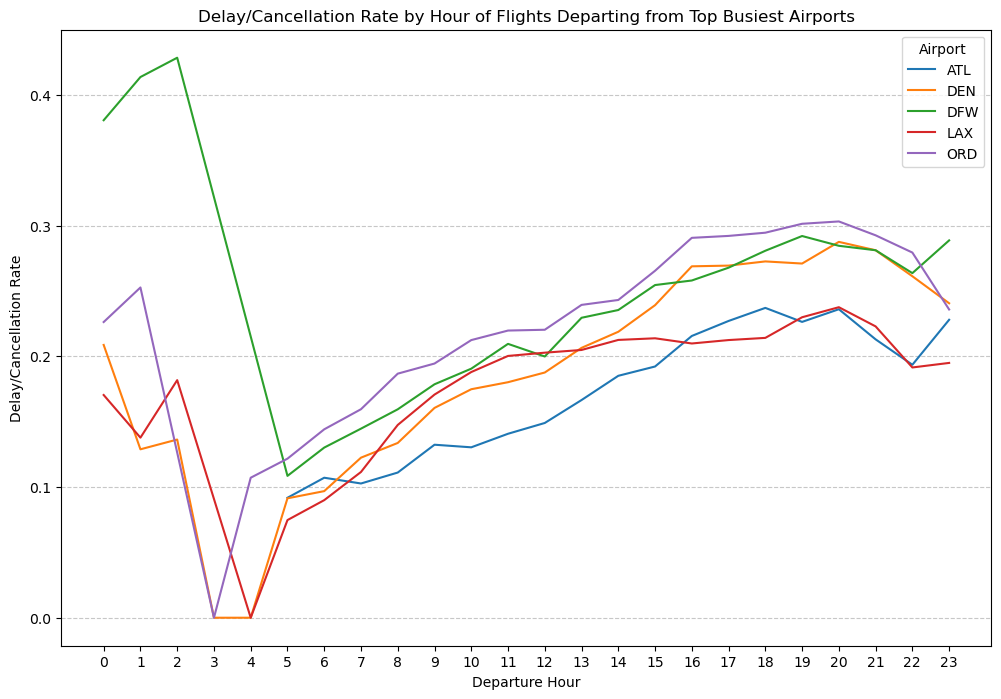

In [13]:
top_airports_delay_cancellation_pd = top_airports_delay_cancellation.select("Origin", "DepHour", "Probability").orderBy("Origin", "DepHour").toPandas()

# Plot line graph for all hours for each airport
plt.figure(figsize=(12, 8))
airports = top_airports_delay_cancellation_pd["Origin"].unique()

# Plot each airport's data
for airport in airports:
    airport_data = top_airports_delay_cancellation_pd[top_airports_delay_cancellation_pd["Origin"] == airport]
    plt.plot(
        airport_data["DepHour"],
        airport_data["Probability"],
        label=airport
    )

plt.xlabel("Departure Hour")
plt.ylabel("Delay/Cancellation Rate")
plt.title("Delay/Cancellation Rate by Hour of Flights Departing from Top Busiest Airports")
plt.xticks(range(0, 24))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Airport")
plt.show()

##### 2.3.2 for flights arriving at the top airports

In [14]:
df = df.withColumn("ArrHour", hour(col("CRSArrTime")))
df = df.filter(col("ArrHour").isNotNull())

In [18]:
top_airports_df = df.filter(col("Dest").isin(top_airports))

top_airports_delay_cancellation = top_airports_df.groupBy("Dest", "ArrHour").agg(
    count("*").alias("TotalFlights"),
    count(when((col("status") == "Delayed"), 1)).alias("TotalDelays"),
    sum(col("Cancelled").cast("int")).alias("TotalCancellations")
)

top_airports_delay_cancellation = top_airports_delay_cancellation.withColumn(
    "Probability", (col("TotalDelays") + col("TotalCancellations")) / col("TotalFlights")
)

window_spec = Window.partitionBy("Dest").orderBy(desc("Probability"))
ranked_hours = top_airports_delay_cancellation.withColumn("Rank", row_number().over(window_spec))

# Select only the top 3 peak hours for each airport
top_peak_hours = ranked_hours.filter(col("Rank") <= 3)
top_peak_hours.orderBy("Dest", "Rank").show()

+----+-------+------------+-----------+------------------+-------------------+----+
|Dest|ArrHour|TotalFlights|TotalDelays|TotalCancellations|        Probability|Rank|
+----+-------+------------+-----------+------------------+-------------------+----+
| ATL|      1|        1212|        423|                64| 0.4018151815181518|   1|
| ATL|      2|          66|         16|                 3| 0.2878787878787879|   2|
| ATL|      0|       14029|       3674|               300|0.28327036852234655|   3|
| DEN|      3|          31|         13|                 0|0.41935483870967744|   1|
| DEN|      1|        3456|       1090|               125|          0.3515625|   2|
| DEN|      0|       17464|       4422|               429| 0.2777714154832799|   3|
| DFW|     22|       58221|      13802|              1335|  0.259992099070782|   1|
| DFW|     21|      147058|      33096|              5093|0.25968665424526377|   2|
| DFW|     20|      157743|      36487|              4465|0.2596121539466093

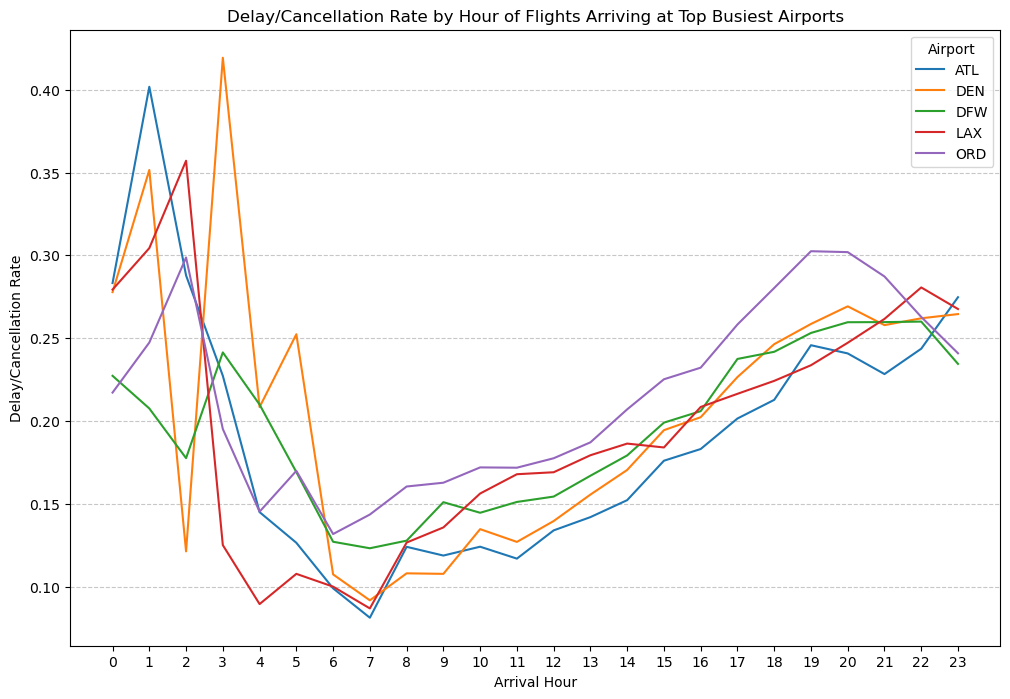

In [19]:
top_airports_delay_cancellation_pd = top_airports_delay_cancellation.select("Dest", "ArrHour", "Probability").orderBy("Dest", "ArrHour").toPandas()

# Plot line graph for all hours for each airport
plt.figure(figsize=(12, 8))
airports = top_airports_delay_cancellation_pd["Dest"].unique()

# Plot each airport's data
for airport in airports:
    airport_data = top_airports_delay_cancellation_pd[top_airports_delay_cancellation_pd["Dest"] == airport]
    plt.plot(
        airport_data["ArrHour"],
        airport_data["Probability"],
        label=airport
    )

plt.xlabel("Arrival Hour")
plt.ylabel("Delay/Cancellation Rate")
plt.title("Delay/Cancellation Rate by Hour of Flights Arriving at Top Busiest Airports")
plt.xticks(range(0, 24))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Airport")
plt.show()

#### 2.4 Peak day of the year when depart-delays/cancellation are most likely for all flights

In [17]:
df = df.withColumn("DepMonth", month(col("CRSDepTime")))
df = df.withColumn("DepDay", dayofmonth(col("CRSDepTime")))
df = df.filter(col("DepMonth").isNotNull() & col("DepDay").isNotNull())

delay_cancellation_by_day = df.groupBy("DepMonth", "DepDay").agg(
    count("*").alias("TotalFlights"),
    count(when((col("status") == "Delayed"), 1)).alias("TotalDelays"),
    sum(col("Cancelled").cast("int")).alias("TotalCancellations")
)
delay_cancellation_by_day = delay_cancellation_by_day.withColumn(
    "Probability", (col("TotalDelays") + col("TotalCancellations")) / col("TotalFlights")
)

peak_days = delay_cancellation_by_day.orderBy(col("Probability").desc())
peak_days.show()

+--------+------+------------+-----------+------------------+-------------------+
|DepMonth|DepDay|TotalFlights|TotalDelays|TotalCancellations|        Probability|
+--------+------+------------+-----------+------------------+-------------------+
|      12|    27|      208660|      58550|              8041| 0.3191363941339979|
|      12|    26|      205674|      55830|              8086| 0.3107636356564272|
|       1|     3|      226894|      59682|              8314|0.29968178973441345|
|       1|     2|      229311|      60850|              6732|0.29471765419016094|
|      12|    30|      204595|      55221|              3990| 0.2894058994599086|
|      12|    21|      206921|      55753|              2726|0.28261510431517345|
|      12|    29|      201857|      52415|              4513| 0.2820214310130439|
|       1|     4|      219002|      52919|              8483| 0.2803718687500571|
|       7|    23|      216070|      55370|              4617|0.27762762067848384|
|      12|    28

In [21]:
from pyspark.sql.functions import concat_ws

# Combine month and day into a single column for plotting purposes
delay_cancellation_by_day = delay_cancellation_by_day.withColumn(
    "DepDate", concat_ws("-", col("DepMonth"), col("DepDay"))
)

delay_cancellation_by_day_pd = (
    delay_cancellation_by_day.select("DepDate", "Probability")
    .orderBy("DepMonth", "DepDay")
    .toPandas()
)

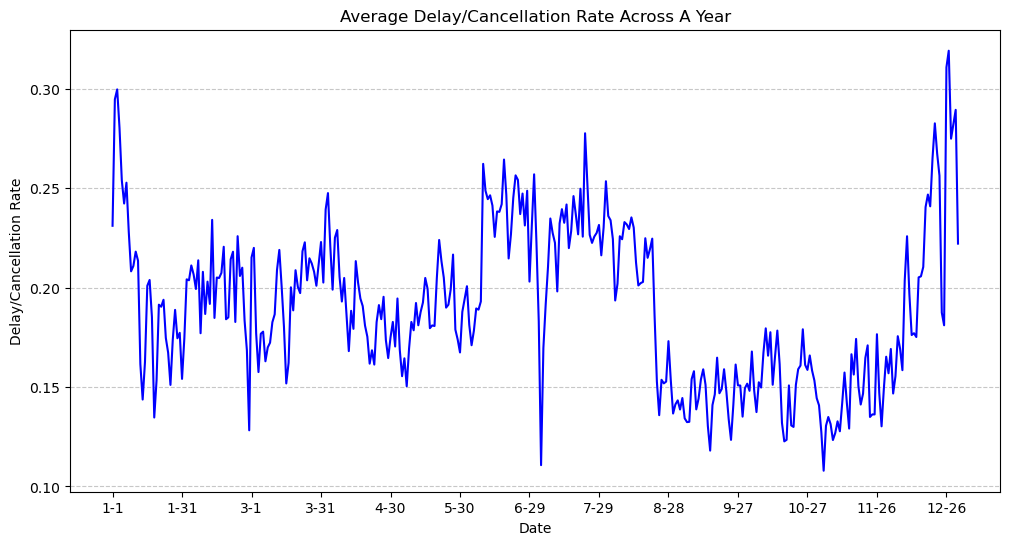

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(
    delay_cancellation_by_day_pd["DepDate"],
    delay_cancellation_by_day_pd["Probability"],
    linestyle="-",
    color="b",
    label="Probability of Delay/Cancellation"
)
plt.xlabel("Date")
plt.ylabel("Delay/Cancellation Rate")
plt.title("Average Delay/Cancellation Rate Across A Year")
plt.xticks(
    ticks=range(0, len(delay_cancellation_by_day_pd["DepDate"]), len(delay_cancellation_by_day_pd["DepDate"]) // 12),
    rotation=0
)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

#### 2.5 Peak day of the year when depart-delays/cancellation are most likely at top 5 busiest airports

##### 2.5.1 for flights departing from the top airports

In [28]:
top_airports = ["ATL", "ORD", "DFW", "DEN", "LAX"]
top_airports_df = df.filter(col("Origin").isin(top_airports))

delay_cancellation_by_day_airport = top_airports_df.groupBy("Origin", "DepMonth", "DepDay").agg(
    count("*").alias("TotalFlights"),
    count(when((col("status") == "Delayed"), 1)).alias("TotalDelays"),
    sum(col("Cancelled").cast("int")).alias("TotalCancellations")
)
delay_cancellation_by_day_airport = delay_cancellation_by_day_airport.withColumn(
    "Probability", (col("TotalDelays") + col("TotalCancellations")) / col("TotalFlights")
)

delay_cancellation_by_day_airport = delay_cancellation_by_day_airport.withColumn(
    "DepDate", concat_ws("-", col("DepMonth"), col("DepDay"))
)

window_spec = Window.partitionBy("Origin").orderBy(desc("Probability"))
ranked_days = delay_cancellation_by_day_airport.withColumn("Rank", row_number().over(window_spec))

# Select only the top 3 peak days for each airport
top_peak_days = ranked_days.filter(col("Rank") <= 3)
top_peak_days.orderBy("Origin", "Rank").show()

+------+--------+------+------------+-----------+------------------+-------------------+-------+----+
|Origin|DepMonth|DepDay|TotalFlights|TotalDelays|TotalCancellations|        Probability|DepDate|Rank|
+------+--------+------+------------+-----------+------------------+-------------------+-------+----+
|   ATL|       7|    21|       12517|       4025|               155|0.33394583366621394|   7-21|   1|
|   ATL|       8|     8|       12904|       3482|               555|0.31284872907625544|    8-8|   2|
|   ATL|       8|     9|       13022|       3649|               390| 0.3101674090001536|    8-9|   3|
|   DEN|      12|    26|        8053|       3133|               215| 0.4157456848379486|  12-26|   1|
|   DEN|      12|    30|        8077|       2900|               235|0.38813916057942305|  12-30|   2|
|   DEN|      12|    31|        6442|       2158|               268| 0.3765911207699472|  12-31|   3|
|   DFW|      12|    27|        8579|       2774|               614| 0.39491782259

In [29]:
delay_cancellation_by_day_airport_pd = (
    delay_cancellation_by_day_airport.select("Origin", "DepDate", "Probability")
    .orderBy("Origin", "DepMonth", "DepDay")
    .toPandas()
)

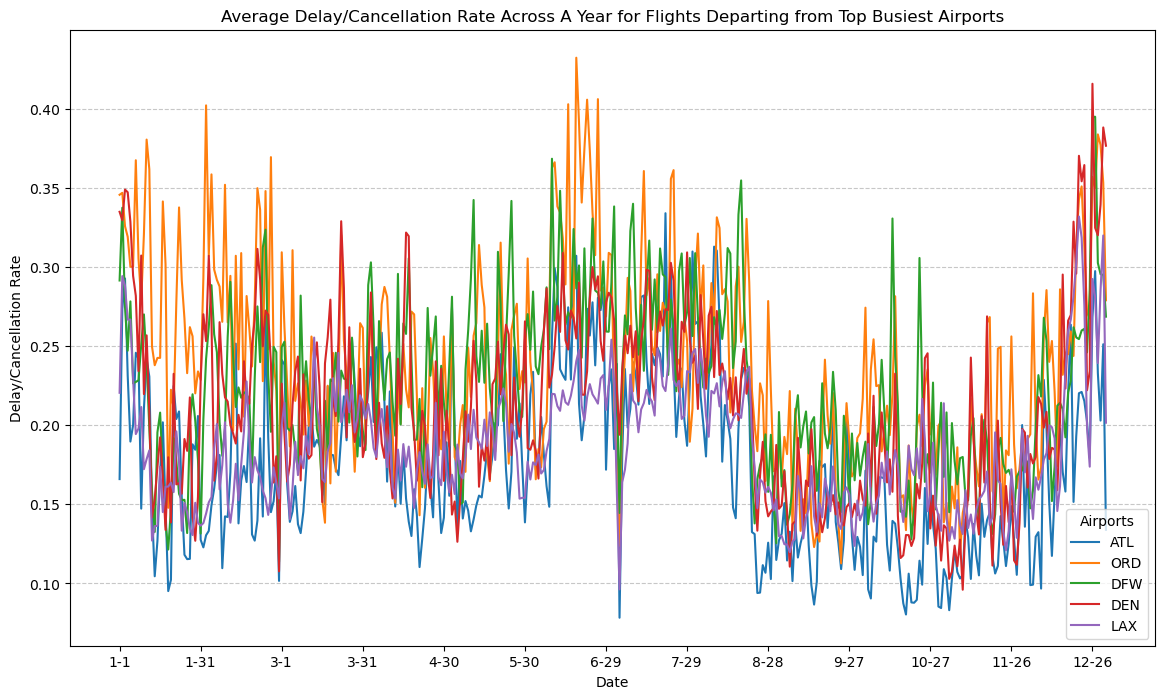

In [30]:
plt.figure(figsize=(14, 8))
for airport in top_airports:
    airport_data = delay_cancellation_by_day_airport_pd[delay_cancellation_by_day_airport_pd["Origin"] == airport]
    plt.plot(
        airport_data["DepDate"],
        airport_data["Probability"],
        linestyle="-",
        label= airport
    )

plt.xlabel("Date")
plt.ylabel("Delay/Cancellation Rate")
plt.title("Average Delay/Cancellation Rate Across A Year for Flights Departing from Top Busiest Airports")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(
    ticks=range(0, 367, 30),
    rotation=0
)
plt.legend(title="Airports")
plt.show()

##### 2.5.2 for flights arriving at the top airports

In [13]:
df = df.withColumn("ArrMonth", month(col("CRSArrTime")))
df = df.withColumn("ArrDay", dayofmonth(col("CRSArrTime")))
df = df.filter(col("ArrMonth").isNotNull() & col("ArrDay").isNotNull())

In [32]:
top_airports_df = df.filter(col("Dest").isin(top_airports))

delay_cancellation_by_day_airport = top_airports_df.groupBy("Dest", "ArrMonth", "ArrDay").agg(
    count("*").alias("TotalFlights"),
    count(when((col("status") == "Delayed"), 1)).alias("TotalDelays"),
    sum(col("Cancelled").cast("int")).alias("TotalCancellations")
)
delay_cancellation_by_day_airport = delay_cancellation_by_day_airport.withColumn(
    "Probability", (col("TotalDelays") + col("TotalCancellations")) / col("TotalFlights")
)

delay_cancellation_by_day_airport = delay_cancellation_by_day_airport.withColumn(
    "ArrDate", concat_ws("-", col("ArrMonth"), col("ArrDay"))
)

window_spec = Window.partitionBy("Dest").orderBy(desc("Probability"))
ranked_days = delay_cancellation_by_day_airport.withColumn("Rank", row_number().over(window_spec))

# Select only the top 3 peak days for each airport
top_peak_days = ranked_days.filter(col("Rank") <= 3)
top_peak_days.orderBy("Dest", "Rank").show()

+----+--------+------+------------+-----------+------------------+-------------------+-------+----+
|Dest|ArrMonth|ArrDay|TotalFlights|TotalDelays|TotalCancellations|        Probability|ArrDate|Rank|
+----+--------+------+------------+-----------+------------------+-------------------+-------+----+
| ATL|      12|    27|       12330|       3337|               271|0.29261962692619625|  12-27|   1|
| ATL|       8|     9|       13047|       3171|               514|0.28244040775657236|    8-9|   2|
| ATL|       7|    21|       12525|       3381|               153| 0.2821556886227545|   7-21|   3|
| DEN|      12|    26|        8041|       2653|               185|0.35294117647058826|  12-26|   1|
| DEN|      12|    30|        8063|       2560|               235|0.34664516929182687|  12-30|   2|
| DEN|      12|    22|        7977|       2408|               113| 0.3160335965901968|  12-22|   3|
| DFW|      12|    27|        8592|       2233|               786| 0.3513733705772812|  12-27|   1|


In [33]:
delay_cancellation_by_day_airport_pd = (
    delay_cancellation_by_day_airport.select("Dest", "ArrDate", "Probability")
    .orderBy("Dest", "ArrMonth", "ArrDay")
    .toPandas()
)

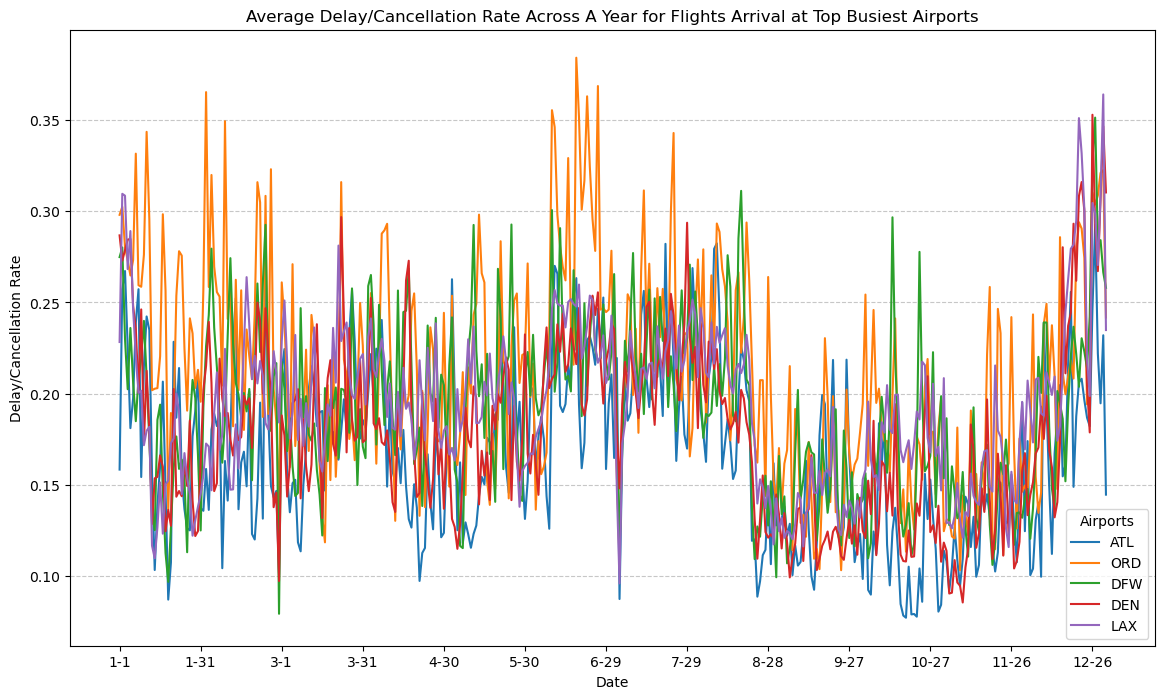

In [34]:
plt.figure(figsize=(14, 8))
for airport in top_airports:
    airport_data = delay_cancellation_by_day_airport_pd[delay_cancellation_by_day_airport_pd["Dest"] == airport]
    plt.plot(
        airport_data["ArrDate"],
        airport_data["Probability"],
        linestyle="-",
        label= airport
    )

plt.xlabel("Date")
plt.ylabel("Delay/Cancellation Rate")
plt.title("Average Delay/Cancellation Rate Across A Year for Flights Arrival at Top Busiest Airports")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(
    ticks=range(0, 367, 30),
    rotation=0
)
plt.legend(title="Airports")
plt.show()

#### 2.6 top 5 largest airlines

In [49]:
busiest_airlines = df.groupBy("Airline").count().orderBy("count", ascending=False).limit(5)
busiest_airlines.show()

+-------+--------+
|Airline|   count|
+-------+--------+
|     WN|14854380|
|     DL| 9683093|
|     AA| 8484319|
|     OO| 8054185|
|     UA| 5933721|
+-------+--------+



Southwest, Delta, American airlines, Skywest and United airlines are the top 5 largest airlines 

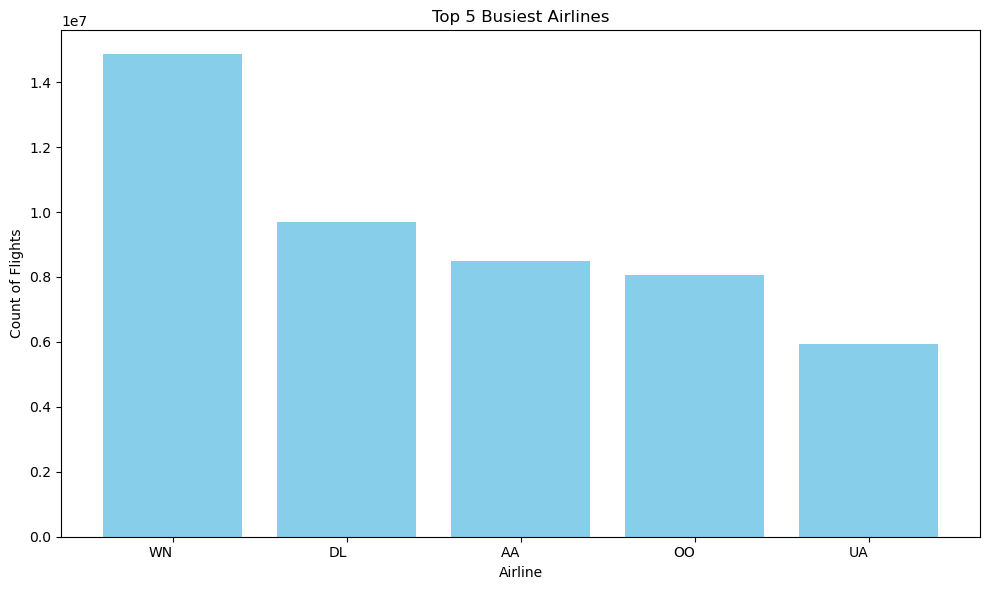

In [50]:
# Assuming busiest_airlines DataFrame is already created and contains 'Airline' and 'count'
busiest_airlines_pd = busiest_airlines.toPandas()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(busiest_airlines_pd['Airline'], busiest_airlines_pd['count'], color='skyblue')

# Adding titles and labels
plt.title('Top 5 Busiest Airlines')
plt.xlabel('Airline')
plt.ylabel('Count of Flights')

# Rotating x-axis labels for readability
plt.xticks(rotation=0, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

### 2.7 Rank of cancellation rate + delay rate (15min - 2:59h) + delay>3h rate by airlines

In [51]:
df_can=df.filter(col("Cancelled")==True).groupBy("Airline").count()
df_can=df_can.withColumnRenamed("count","cancellation numbers")

In [52]:
df_delay1=df.filter((col("ArrDelayMinutes") > 15)&(col("ArrDelayMinutes") < 180)).groupBy("Airline").count()
df_delay1=df_delay1.withColumnRenamed("count","Delay within 3 hours")

In [53]:
df_delay2=df.filter(col("ArrDelayMinutes") >= 180).groupBy("Airline").count()
df_delay2=df_delay2.withColumnRenamed("count","Severe Delay exceeding 3 hours")

In [54]:
can_cc=df_can.join(df_airline,on="Airline",how="inner")
can_cal=can_cc.withColumn("Cancellation Rate", col("cancellation numbers")/col("count") *100).orderBy("Cancellation Rate",ascending=False)
can_cal=can_cal.withColumn("Cancellation Rate", F.format_number(col("cancellation Rate"), 1))
can_cal.show(10,truncate=False)

+-------+--------------------+-------+-----------------+
|Airline|cancellation numbers|count  |Cancellation Rate|
+-------+--------------------+-------+-----------------+
|AX     |1618                |18705  |8.7              |
|CP     |1193                |15878  |7.5              |
|EM     |343                 |5202   |6.6              |
|G4     |21785               |384095 |5.7              |
|G7     |6877                |133925 |5.1              |
|ZW     |7367                |174545 |4.2              |
|OH     |44327               |1128159|3.9              |
|PT     |8309                |224517 |3.7              |
|C5     |5530                |153986 |3.6              |
|YX     |37699               |1066669|3.5              |
+-------+--------------------+-------+-----------------+
only showing top 10 rows



In [56]:
can_rate=can_cal.select("Airline","Cancellation Rate").withColumn("Cancellation Rate", F.col("Cancellation Rate").cast("double"))
can_rate=can_rate.withColumn("Cancellation Rate", F.format_number(col("Cancellation Rate"), 1))
can_rate.show()
window_c = Window.orderBy(col("Cancellation Rate").desc())
canrank = can_rate.withColumn("Cancellation Rate Rank", row_number().over(window_c))
can_calpd=canrank.toPandas()

24/12/03 01:47:36 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 01:47:36 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------+-----------------+
|Airline|Cancellation Rate|
+-------+-----------------+
|     AX|              8.7|
|     CP|              7.5|
|     EM|              6.6|
|     G4|              5.7|
|     G7|              5.1|
|     ZW|              4.2|
|     OH|              3.9|
|     PT|              3.7|
|     C5|              3.6|
|     YX|              3.5|
|     MQ|              3.5|
|     EV|              3.0|
|     QX|              2.8|
|     YV|              2.7|
|     XE|              2.5|
|     9E|              2.3|
|     NK|              2.3|
|     B6|              2.1|
|     AA|              2.1|
|     OO|              2.0|
+-------+-----------------+
only showing top 20 rows



24/12/03 01:48:12 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 01:48:16 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 01:48:39 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 01:48:41 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 01:48:41 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

In [57]:
can_calpd.head(10)

,Airline,Cancellation Rate,Cancellation Rate Rank
0,AX,8.7,1
1,CP,7.5,2
2,EM,6.6,3
3,G4,5.7,4
4,G7,5.1,5
5,ZW,4.2,6
6,OH,3.9,7
7,PT,3.7,8
8,C5,3.6,9
9,MQ,3.5,10


In [58]:
# DELAY LESS THAN 3 HOURS:
d1_cc=df_delay1.join(df_airline,on="Airline",how="inner")
d1_cal=d1_cc.withColumn("Delay Rate", col("Delay within 3 hours")/col("count") *100).orderBy("Delay Rate",ascending=False)
d1_cal=d1_cal.withColumn("Delay Rate", F.format_number(col("Delay Rate"), 1))
d1_cal.show(10,truncate=False)
d1_calpd=d1_cal.toPandas()

+-------+--------------------+-------+----------+
|Airline|Delay within 3 hours|count  |Delay Rate|
+-------+--------------------+-------+----------+
|G4     |82969               |384095 |21.6      |
|B6     |636262              |2987541|21.3      |
|F9     |250010              |1218090|20.5      |
|EV     |924283              |4778656|19.3      |
|NK     |196402              |1044197|18.8      |
|VX     |73121               |389059 |18.8      |
|XE     |201517              |1105864|18.2      |
|MQ     |691611              |3834204|18.0      |
|C5     |27681               |153986 |18.0      |
|CO     |132744              |740498 |17.9      |
+-------+--------------------+-------+----------+
only showing top 10 rows



In [59]:
d1_rate=d1_cal.select("Airline","Delay Rate").withColumn("Delay Rate", F.col("Delay Rate").cast("double"))
d1_rate.show()

+-------+----------+
|Airline|Delay Rate|
+-------+----------+
|     G4|      21.6|
|     B6|      21.3|
|     F9|      20.5|
|     EV|      19.3|
|     NK|      18.8|
|     VX|      18.8|
|     XE|      18.2|
|     MQ|      18.0|
|     C5|      18.0|
|     CO|      17.9|
|     NW|      17.5|
|     WN|      17.5|
|     OH|      17.3|
|     AA|      17.2|
|     UA|      16.5|
|     G7|      15.6|
|     US|      15.5|
|     FL|      15.4|
|     OO|      15.4|
|     YV|      15.2|
+-------+----------+
only showing top 20 rows



In [60]:
windowd1 = Window.orderBy(col("Delay Rate").desc())
d1rank = d1_rate.withColumn("Delay Rate Rank", row_number().over(windowd1))
d1_calpd=d1rank.toPandas()

24/12/03 01:52:05 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 01:52:05 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 01:52:44 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 01:52:46 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 01:52:52 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

In [61]:
d1_calpd.head(10)

,Airline,Delay Rate,Delay Rate Rank
0,G4,21.6,1
1,B6,21.3,2
2,F9,20.5,3
3,EV,19.3,4
4,VX,18.8,5
5,NK,18.8,6
6,XE,18.2,7
7,C5,18.0,8
8,MQ,18.0,9
9,CO,17.9,10


In [62]:
# DELAY EXCEEDING 3 HOURS:
d2_cc=df_delay2.join(df_airline,on="Airline",how="inner")
d2_cal=d2_cc.withColumn("Severe Delay Rate", col("Severe Delay exceeding 3 hours")/col("count") *100).orderBy("Severe Delay Rate",ascending=False)
d2_cal=d2_cal.withColumn("Severe Delay Rate", F.format_number(col("Severe Delay Rate"), 1))
d2_cal.show(10,truncate=False)

+-------+------------------------------+-------+-----------------+
|Airline|Severe Delay exceeding 3 hours|count  |Severe Delay Rate|
+-------+------------------------------+-------+-----------------+
|C5     |3213                          |153986 |2.1              |
|G4     |6723                          |384095 |1.8              |
|G7     |2063                          |133925 |1.5              |
|ZW     |2634                          |174545 |1.5              |
|B6     |41018                         |2987541|1.4              |
|EV     |60351                         |4778656|1.3              |
|F9     |14851                         |1218090|1.2              |
|NK     |12231                         |1044197|1.2              |
|AX     |208                           |18705  |1.1              |
|OH     |12527                         |1128159|1.1              |
+-------+------------------------------+-------+-----------------+
only showing top 10 rows



In [63]:
d2_rate=d2_cal.select("Airline","Severe Delay Rate").withColumn("Severe Delay Rate", F.col("Severe Delay Rate").cast("double"))
d2_rate.show()

+-------+-----------------+
|Airline|Severe Delay Rate|
+-------+-----------------+
|     C5|              2.1|
|     G4|              1.8|
|     G7|              1.5|
|     ZW|              1.5|
|     B6|              1.4|
|     EV|              1.3|
|     F9|              1.2|
|     NK|              1.2|
|     AX|              1.1|
|     OH|              1.1|
|     VX|              1.0|
|     YV|              1.0|
|     UA|              1.0|
|     XE|              1.0|
|     PT|              1.0|
|     OO|              0.9|
|     AA|              0.9|
|     YX|              0.8|
|     9E|              0.8|
|     DL|              0.8|
+-------+-----------------+
only showing top 20 rows



In [64]:
windowd2 = Window.orderBy(col("Severe Delay Rate").desc())
d2rank = d2_rate.withColumn("Severe Delay Rate Rank", row_number().over(windowd2))
d2_calpd=d2rank.toPandas()

24/12/03 01:54:22 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 01:54:22 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 01:54:57 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 01:54:59 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 01:55:06 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

In [65]:
d2_calpd.head()

,Airline,Severe Delay Rate,Severe Delay Rate Rank
0,C5,2.1,1
1,G4,1.8,2
2,G7,1.5,3
3,ZW,1.5,4
4,B6,1.4,5


In [66]:
df_total=canrank.join(d1rank,on="Airline",how="inner")
df_total=df_total.join(d2rank,on="Airline",how="inner")
df_aa=df_total.select("Airline","Cancellation Rate","Cancellation Rate Rank","Delay Rate","Delay Rate Rank","Severe Delay Rate","Severe Delay Rate Rank")

df_aapd = df_aa.toPandas() 

24/12/03 01:55:07 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 01:55:07 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 01:55:07 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 01:55:43 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 01:55:43 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

In [67]:
df_with_rank_sum = df_aa.withColumn("Total Rank", 
                                F.col("Cancellation Rate Rank") + 
                                F.col("Delay Rate Rank") + 
                                F.col("Severe Delay Rate Rank"))

# Sort by the total rank in ascending order
df_sorted_by_rank_sum = df_with_rank_sum.orderBy("Total Rank", ascending=True)

In [68]:
rankttpd=df_sorted_by_rank_sum.toPandas()
rankttpd.head(10)

24/12/03 01:56:21 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 01:56:21 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 01:56:21 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 01:56:56 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 01:56:56 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

,Airline,Cancellation Rate,Cancellation Rate Rank,Delay Rate,Delay Rate Rank,Severe Delay Rate,Severe Delay Rate Rank,Total Rank
0,G4,5.7,4,21.6,1,1.8,2,7
1,C5,3.6,9,18.0,9,2.1,1,19
2,EV,3.0,12,19.3,4,1.3,6,22
3,G7,5.1,5,15.6,16,1.5,3,24
4,B6,2.1,18,21.3,2,1.4,5,25
5,OH,3.9,7,17.3,13,1.1,9,29
6,NK,2.3,17,18.8,5,1.2,8,30
7,AX,8.7,1,15.2,21,1.1,10,32
8,ZW,4.2,6,13.3,23,1.5,4,33
9,F9,1.3,24,20.5,3,1.2,7,34


#### 2. Rank of cancellation + delay rate (15min - 2:59h) + delay>3h rate by airport

##### 2.8.1 by departing airports

In [70]:
dep_airport=df.groupBy("Origin").count()

dep_can=df.filter(col("Cancelled")==True).groupBy("Origin").count()
dep_can=dep_can.withColumnRenamed("count","cancellation numbers")

dep_delay1=df.filter((col("ArrDelayMinutes") > 15)&(col("ArrDelayMinutes") < 180)).groupBy("Origin").count()
dep_delay1=dep_delay1.withColumnRenamed("count","Delay within 3 hours")
dep_delay2=df.filter(col("ArrDelayMinutes") >= 180).groupBy("Origin").count()
dep_delay2=dep_delay2.withColumnRenamed("count","Severe Delay exceeding 3 hours")

can2cc=dep_can.join(dep_airport,on="Origin",how="inner")
can2_cal=can2cc.withColumn("Cancellation Rate", col("cancellation numbers")/col("count") *100).orderBy("Cancellation Rate",ascending=False)
can2_cal=can2_cal.withColumn("Cancellation Rate", F.format_number(col("cancellation Rate"), 1))

can2_rate=can2_cal.select("Origin","Cancellation Rate").withColumn("Cancellation Rate", F.col("Cancellation Rate").cast("double"))
can2_rate.show()

+------+-----------------+
|Origin|Cancellation Rate|
+------+-----------------+
|   JHM|             28.7|
|   MMH|             17.3|
|   BFM|             14.9|
|   TEX|             11.9|
|   HVN|              9.2|
|   CDB|              8.4|
|   USA|              8.4|
|   SUN|              8.0|
|   ASE|              7.6|
|   MOD|              7.3|
|   OGS|              7.2|
|   UIN|              7.1|
|   TBN|              6.9|
|   ADQ|              6.8|
|   CMX|              6.8|
|   CEC|              6.6|
|   PVU|              6.5|
|   ORH|              6.5|
|   SCK|              6.3|
|   FOE|              6.2|
+------+-----------------+
only showing top 20 rows



In [71]:
can2_rank=can2_rate.withColumn("Cancellation Rate Rank",row_number().over(window_c))
can2_rankpd=can2_rank.toPandas()
can2_rankpd.head()

24/12/03 02:09:00 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 02:09:00 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 02:10:46 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 02:10:50 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 02:11:35 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

,Origin,Cancellation Rate,Cancellation Rate Rank
0,JHM,28.7,1
1,MMH,17.3,2
2,BFM,14.9,3
3,TEX,11.9,4
4,HVN,9.2,5


In [72]:
delay12cc=dep_delay1.join(dep_airport,on="Origin",how="inner")
d12_cal=delay12cc.withColumn("Delay Rate", col("Delay within 3 hours")/col("count") *100).orderBy("Delay Rate",ascending=False)
d12_cal=d12_cal.withColumn("Delay Rate", F.format_number(col("Delay Rate"), 1))

# Delete the raw cases: EFD/MCN/YNG
d12_cal=d12_cal.filter(col("count")>50)
d12_cal.show(10,truncate=False)

+------+--------------------+-----+----------+
|Origin|Delay within 3 hours|count|Delay Rate|
+------+--------------------+-----+----------+
|CDB   |122                 |262  |46.6      |
|CEC   |1905                |6199 |30.7      |
|OTH   |2364                |7815 |30.2      |
|HGR   |179                 |641  |27.9      |
|ADK   |360                 |1310 |27.5      |
|OGD   |97                  |355  |27.3      |
|SCK   |671                 |2486 |27.0      |
|ILG   |355                 |1320 |26.9      |
|PSM   |320                 |1208 |26.5      |
|LCK   |1049                |3988 |26.3      |
+------+--------------------+-----+----------+
only showing top 10 rows



In [73]:
d12_rate=d12_cal.select("Origin","Delay Rate").withColumn("Delay Rate", F.col("Delay Rate").cast("double"))
d12_rank=d12_rate.withColumn("Delay Rate Rank",row_number().over(windowd1))
d12_rankpd=d12_rank.toPandas()
d12_rankpd.head()

24/12/03 02:14:49 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 02:14:49 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 02:17:57 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 02:17:58 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 02:18:01 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

,Origin,Delay Rate,Delay Rate Rank
0,CDB,46.6,1
1,CEC,30.7,2
2,OTH,30.2,3
3,HGR,27.9,4
4,ADK,27.5,5


In [74]:
delay22cc=dep_delay2.join(dep_airport,on="Origin",how="inner")
d22_cal=delay22cc.withColumn("Severe Delay Rate", col("Severe Delay exceeding 3 hours")/col("count") *100).orderBy("Severe Delay Rate",ascending=False)
d22_cal=d22_cal.withColumn("Severe Delay Rate", F.format_number(col("Severe Delay Rate"), 1))
d22_cal.show(10,truncate=False)

+------+------------------------------+-----+-----------------+
|Origin|Severe Delay exceeding 3 hours|count|Severe Delay Rate|
+------+------------------------------+-----+-----------------+
|PPG   |31                            |753  |4.1              |
|CKB   |125                           |3236 |3.9              |
|RIW   |49                            |1321 |3.7              |
|OGS   |61                            |1682 |3.6              |
|ALS   |35                            |991  |3.5              |
|EAR   |78                            |2295 |3.4              |
|JST   |37                            |1147 |3.2              |
|PQI   |42                            |1337 |3.1              |
|SHD   |78                            |2549 |3.1              |
|SLN   |77                            |2534 |3.0              |
+------+------------------------------+-----+-----------------+
only showing top 10 rows



In [75]:
d22_rate=d22_cal.select("Origin","Severe Delay Rate").withColumn("Severe Delay Rate", F.col("Severe Delay Rate").cast("double"))
d22_rank=d22_rate.withColumn("Severe Delay Rate Rank",row_number().over(windowd2))
d22_rankpd=d22_rank.toPandas()
d22_rankpd.head()

24/12/03 02:21:07 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 02:21:07 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 02:24:07 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 02:24:08 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 02:24:12 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

,Origin,Severe Delay Rate,Severe Delay Rate Rank
0,PPG,4.1,1
1,CKB,3.9,2
2,RIW,3.7,3
3,OGS,3.6,4
4,ALS,3.5,5


In [76]:
dep_total=can2_rank.join(d12_rank,on="Origin",how="inner")
dep_total=dep_total.join(d22_rank,on="Origin",how="inner")
dep_aa=dep_total.select("Origin","Cancellation Rate","Cancellation Rate Rank","Delay Rate","Delay Rate Rank","Severe Delay Rate","Severe Delay Rate Rank")

dep_aapd =dep_aa.toPandas() 

24/12/03 02:24:12 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 02:24:12 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 02:24:12 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 02:26:47 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 02:26:47 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

In [77]:
dep_aapd.head(10)

,Origin,Cancellation Rate,Cancellation Rate Rank,Delay Rate,Delay Rate Rank,Severe Delay Rate,Severe Delay Rate Rank
0,CDB,8.4,6,46.6,1,0.4,386
1,CEC,6.6,16,30.7,2,1.9,59
2,OTH,4.0,79,30.2,3,1.7,74
3,HGR,4.1,70,27.9,4,2.0,47
4,ADK,5.8,25,27.5,5,0.4,385
5,OGD,5.1,37,27.3,6,0.8,298
6,SCK,6.3,19,27.0,7,2.3,37
7,ILG,1.4,360,26.9,8,2.6,26
8,PSM,4.1,69,26.5,9,2.2,40
9,LCK,5.7,27,26.3,10,3.0,14


When it comes to the origin departing airport, it is the opposite to the airline situations: 
1. The cancellation rate and the delay rate rank matches in most cases.
2. However, the delay rate rank and the severe delay rate rank is reversely correlated.

##### 2.8.2 by arriving airports

In [78]:
arr_airport=df.groupBy("Dest").count()

arr_airport=df.groupBy("Dest").count()
arr_airport.filter(col("count")>50)
arr_airport.orderBy("count",ascending=False).show(10)

arr_can=df.filter(col("Cancelled")==True).groupBy("Dest").count()
arr_can=arr_can.withColumnRenamed("count","cancellation numbers")
arr_delay1=df.filter((col("ArrDelayMinutes") > 15)&(col("ArrDelayMinutes") < 180)).groupBy("Dest").count()
arr_delay1=arr_delay1.withColumnRenamed("count","Delay within 3 hours")
arr_delay2=df.filter(col("ArrDelayMinutes") >= 180).groupBy("Dest").count()
arr_delay2=arr_delay2.withColumnRenamed("count","Severe Delay exceeding 3 hours")

can3cc=arr_can.join(arr_airport,on="Dest",how="inner")
can3_cal=can3cc.withColumn("Cancellation Rate", col("cancellation numbers")/col("count") *100).orderBy("Cancellation Rate",ascending=False)
can3_cal=can3_cal.withColumn("Cancellation Rate", F.format_number(col("cancellation Rate"), 1))
can3_cal.show(10,truncate=False)

+----+-------+
|Dest|  count|
+----+-------+
| ATL|4655545|
| ORD|3685441|
| DFW|3213403|
| DEN|2932167|
| LAX|2552364|
| PHX|2100948|
| IAH|2018504|
| SFO|1878904|
| CLT|1872866|
| LAS|1825867|
+----+-------+
only showing top 10 rows



+----+--------------------+-----+-----------------+
|Dest|cancellation numbers|count|Cancellation Rate|
+----+--------------------+-----+-----------------+
|JHM |90                  |348  |25.9             |
|MMH |304                 |1954 |15.6             |
|BFM |6                   |46   |13.0             |
|HVN |135                 |1633 |8.3              |
|USA |308                 |3916 |7.9              |
|MOD |562                 |7667 |7.3              |
|TBN |35                  |496  |7.1              |
|ADQ |543                 |8095 |6.7              |
|CMX |570                 |8705 |6.5              |
|FOE |29                  |449  |6.5              |
+----+--------------------+-----+-----------------+
only showing top 10 rows



In [79]:
can3_rate=can3_cal.select("Dest","Cancellation Rate").withColumn("Cancellation Rate", F.col("Cancellation Rate").cast("double"))

delay13cc=arr_delay1.join(arr_airport,on="Dest",how="inner")
d13_cal=delay13cc.withColumn("Delay Rate", col("Delay within 3 hours")/col("count") *100).orderBy("Delay Rate",ascending=False)
d13_cal=d13_cal.withColumn("Delay Rate", F.format_number(col("Delay Rate"), 1))

d13_cal=d13_cal.filter(col("count")>50)
d13_cal.show(10,truncate=False)

+----+--------------------+-----+----------+
|Dest|Delay within 3 hours|count|Delay Rate|
+----+--------------------+-----+----------+
|FOE |153                 |449  |34.1      |
|CDB |87                  |262  |33.2      |
|ILG |379                 |1322 |28.7      |
|CEC |1748                |6201 |28.2      |
|BIH |83                  |299  |27.8      |
|PGD |5665                |21333|26.6      |
|MOD |2031                |7667 |26.5      |
|OTH |2023                |7820 |25.9      |
|BQN |4776                |19060|25.1      |
|CIC |1869                |7570 |24.7      |
+----+--------------------+-----+----------+
only showing top 10 rows



In [80]:
d13_rate=d13_cal.select("Dest","Delay Rate").withColumn("Delay Rate", F.col("Delay Rate").cast("double"))

delay23cc=arr_delay2.join(arr_airport,on="Dest",how="inner")
d23_cal=delay23cc.withColumn("Severe Delay Rate", col("Severe Delay exceeding 3 hours")/col("count") *100).orderBy("Severe Delay Rate",ascending=False)
d23_cal=d23_cal.withColumn("Severe Delay Rate", F.format_number(col("Severe Delay Rate"), 1))
d23_cal.show(10,truncate=False)

+----+------------------------------+-----+-----------------+
|Dest|Severe Delay exceeding 3 hours|count|Severe Delay Rate|
+----+------------------------------+-----+-----------------+
|PQI |45                            |1338 |3.4              |
|BIH |9                             |299  |3.0              |
|OGS |50                            |1681 |3.0              |
|CKB |86                            |3232 |2.7              |
|FOD |23                            |873  |2.6              |
|SHD |65                            |2551 |2.5              |
|LCK |98                            |3980 |2.5              |
|PPG |18                            |753  |2.4              |
|SFB |814                           |34081|2.4              |
|PGD |486                           |21333|2.3              |
+----+------------------------------+-----+-----------------+
only showing top 10 rows



In [81]:
d23_rate=d23_cal.select("Dest","Severe Delay Rate").withColumn("Severe Delay Rate", F.col("Severe Delay Rate").cast("double"))

#### 2.8 Distance between airport vs cancellation/delay rate

In [19]:
# Define distance bins
df = df.withColumn(
    "DistanceRange",
    when(col("Distance") <= 500, "0-500")
    .when((col("Distance") > 500) & (col("Distance") <= 1000), "501-1000")
    .when((col("Distance") > 1000) & (col("Distance") <= 1500), "1001-1500")
    .when((col("Distance") > 1500) & (col("Distance") <= 2000), "1501-2000")
    .when((col("Distance") > 2000), "2001+")
)

distance_delay_cancellation = df.groupBy("DistanceRange").agg(
    count("*").alias("TotalFlights"),
    count(when((col("status") == "Delayed") | (col("status") == "Cancelled"), 1)).alias("TotalIssues"),
)

distance_delay_cancellation = distance_delay_cancellation.withColumn(
    "Probability", col("TotalIssues") / col("TotalFlights")
)

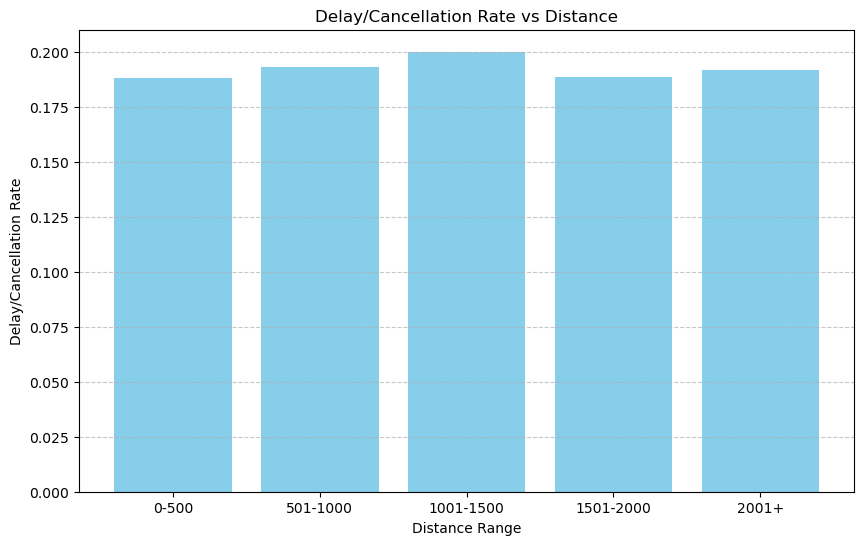

In [20]:
distance_delay_cancellation = distance_delay_cancellation.withColumn(
    "DistanceSort",
    when(col("DistanceRange") == "0-500", 1)
    .when(col("DistanceRange") == "501-1000", 2)
    .when(col("DistanceRange") == "1001-1500", 3)
    .when(col("DistanceRange") == "1501-2000", 4)
    .when(col("DistanceRange") == "2001+", 5)
)
distance_delay_cancellation = distance_delay_cancellation.orderBy("DistanceSort")

distance_delay_cancellation_pd = distance_delay_cancellation.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(distance_delay_cancellation_pd["DistanceRange"], distance_delay_cancellation_pd["Probability"], color='skyblue')
plt.xlabel("Distance Range")
plt.ylabel("Delay/Cancellation Rate")
plt.title("Delay/Cancellation Rate vs Distance")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

### 3. Delay Duration Analysis
#### 3.1 Distribution of delay durations for all flights

In [22]:
delay_duration_df_pd = df.filter(df["ArrDelayMinutes"] > 15).select("ArrDelayMinutes").toPandas()
delay_duration_df_pd["ArrDelayMinutes"] = delay_duration_df_pd["ArrDelayMinutes"].apply(lambda x: 301 if x > 300 else x)

In [23]:
bins = list(range(0, 331, 30))
print(bins)

[0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]


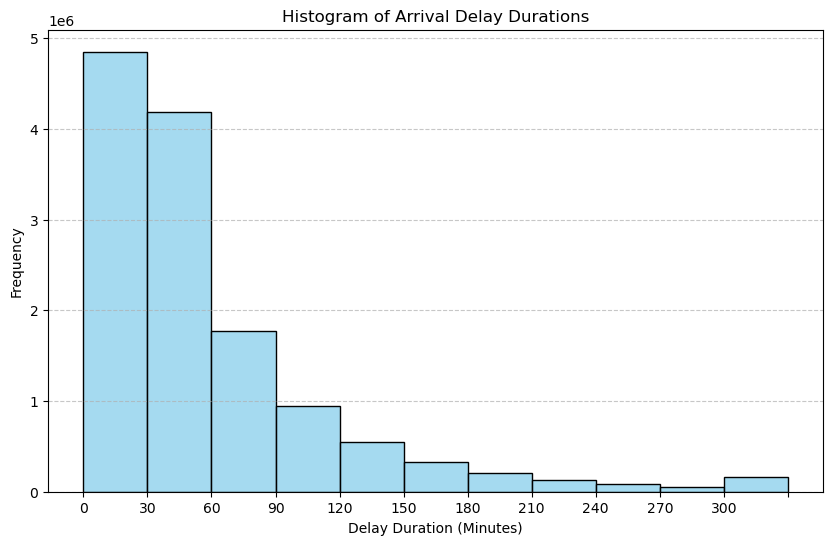

In [24]:
# Plot histogram
plt.figure(figsize=(10, 6))
hist = sns.histplot(
    delay_duration_df_pd["ArrDelayMinutes"], 
    bins=bins, 
    kde=False, 
    color="skyblue"
)

plt.xlabel("Delay Duration (Minutes)")
plt.ylabel("Frequency")
plt.title("Histogram of Arrival Delay Durations")
ticks = list(range(0, 331, 30))
labels = [f"{i}" for i in range(0, 330, 30)] + [" "]
plt.xticks(ticks=ticks, labels=labels)

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

#### 3.2 Rank of avg delay duration by airline

In [69]:
# Entire delay cases
df_dur_num=df.filter(col("ArrDelayMinutes") > 15).groupBy("Airline").count()
df_dur_num=df_dur_num.orderBy("count",ascending=False)

# Entire delay duration time
delaydu= df.groupBy("Airline").agg(F.sum("ArrDelayMinutes").alias("Total Delay Duration"))
delaydu=delaydu.orderBy("Total Delay Duration",ascending=False)

deldur=df_dur_num.join(delaydu,on="Airline",how="inner")
deldur=deldur.withColumn("Avg Delay Duration", col("Total Delay Duration")/col("count")).orderBy("Avg Delay Duration",ascending=False)
deldur=deldur.withColumn("Avg Delay Duration", F.format_number(col("Avg Delay Duration"), 2))
dur_final=deldur.select("Airline","Avg Delay Duration")
dur_finalpd=dur_final.toPandas()
dur_finalpd.head(10)

,Airline,Avg Delay Duration
0,C5,93.14
1,ZW,89.72
2,G7,86.14
3,AX,82.49
4,PT,81.57
5,CP,75.23
6,EM,73.98
7,G4,69.47
8,QX,59.54
9,YX,55.21


#### 3.3 Distribution of delay duration of flights operated by the top 5 busiest airlines

In [25]:
top_5_airlines = ["WN", "DL", "AA", "OO", "UA"]

airline_delay_duration_df = df.filter((df["Airline"].isin(top_5_airlines)) & (df["DepDelayMinutes"] > 15)).select("Airline", "DepDelayMinutes")

binned_delay_df = (
    airline_delay_duration_df.withColumn(
        "DelayBin",
        when(col("DepDelayMinutes") <= 60, "0-60")
        .when((col("DepDelayMinutes") > 60) & (col("DepDelayMinutes") <= 120), "60-120")
        .when((col("DepDelayMinutes") > 120) & (col("DepDelayMinutes") <= 180), "120-180")
        .when((col("DepDelayMinutes") > 180) & (col("DepDelayMinutes") <= 240), "180-240")
        .when((col("DepDelayMinutes") > 240) & (col("DepDelayMinutes") <= 300), "240-300")
        .otherwise(">300")
    )
)

binned_delay_counts = (
    binned_delay_df.groupBy("Airline", "DelayBin")
    .count()
    .orderBy("Airline", "DelayBin")
    .toPandas()
)

binned_delay_pivot = binned_delay_counts.pivot(index="DelayBin", columns="Airline", values="count").fillna(0)

In [26]:
bin_order = ["0-60", "60-120", "120-180", "180-240", "240-300", ">300"]

binned_delay_pivot = binned_delay_pivot.reindex(bin_order)

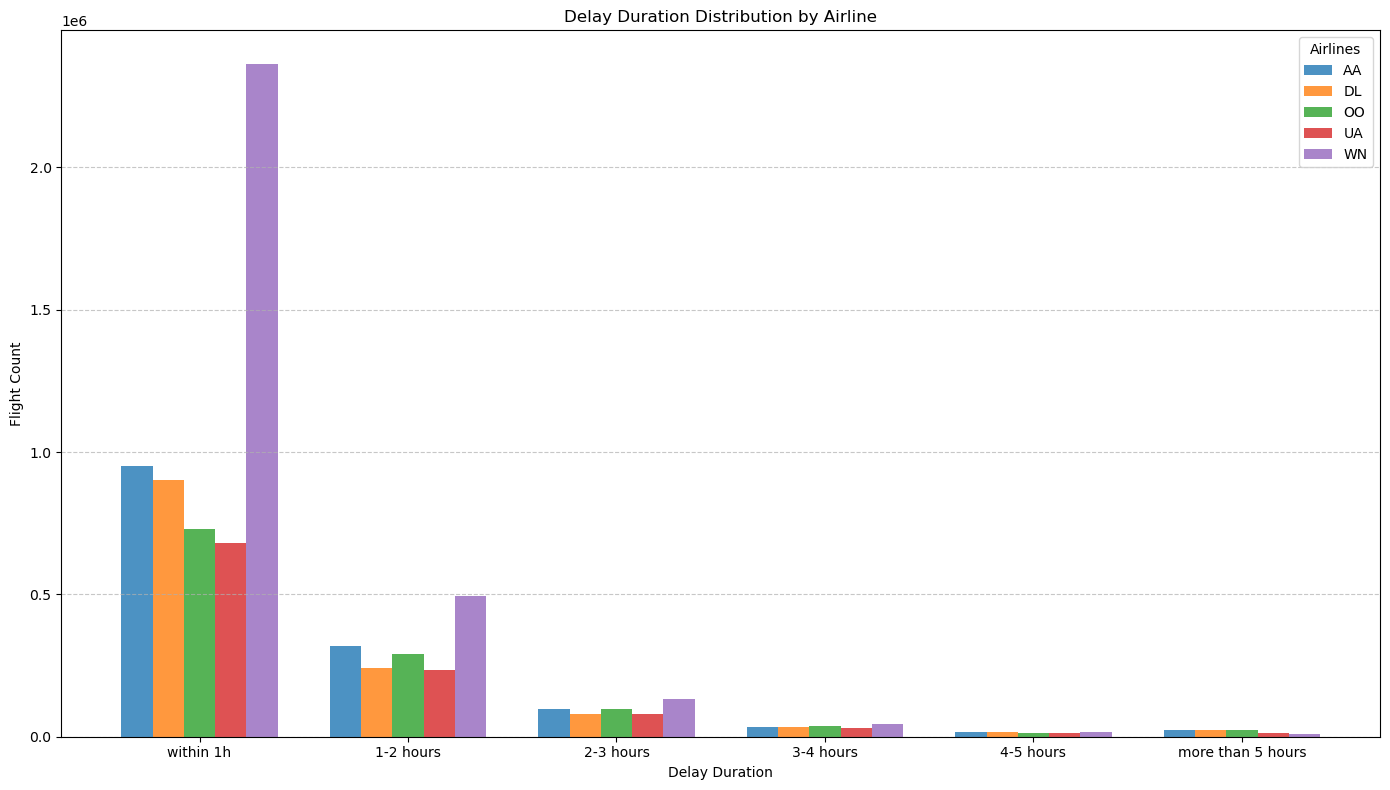

In [27]:
import numpy as np

bar_width = 0.15
x = np.arange(len(binned_delay_pivot.index))

plt.figure(figsize=(14, 8))
for idx, airline in enumerate(binned_delay_pivot.columns):
    plt.bar(
        x + idx * bar_width,
        binned_delay_pivot[airline],
        bar_width,
        label= airline,
        alpha=0.8
    )
labels = ["within 1h", "1-2 hours", "2-3 hours", "3-4 hours", "4-5 hours", "more than 5 hours"]
plt.xticks(x + bar_width * (len(binned_delay_pivot.columns) - 1) / 2, labels = labels)
plt.xlabel("Delay Duration")
plt.ylabel("Flight Count")
plt.title("Delay Duration Distribution by Airline")
plt.legend(title="Airlines")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### 3. correlation

In [11]:
df = df.withColumn(
    "delay_status",
    when(col("ArrDelayMinutes") > 15, "Delayed").otherwise("OnTime")
)
status_indexer = StringIndexer(inputCol="delay_status", outputCol="delay_status_index")
df = status_indexer.fit(df).transform(df)

In [18]:
df.show(5)

+----------+-------+------+----+---------+--------+-------------------+-------------------+---------------+-------------------+---------------+-------+--------------+-----------------+--------+-------------------------------+-------+-------------------+-------------------+------+-------------------+-------------+------------+----------+-------------------------------------+------+------------+------------+------------------+--------+------+-------+-------+--------+------+
|FlightDate|Airline|Origin|Dest|Cancelled|Diverted|         CRSDepTime|            DepTime|DepDelayMinutes|            ArrTime|ArrDelayMinutes|AirTime|CRSElapsedTime|ActualElapsedTime|Distance|Flight_Number_Operating_Airline|TaxiOut|          WheelsOff|           WheelsOn|TaxiIn|         CRSArrTime|Airline_index|Origin_index|Dest_index|Flight_Number_Operating_Airline_index|status|status_index|delay_status|delay_status_index|ArrMonth|ArrDay|ArrHour|DepHour|DepMonth|DepDay|
+----------+-------+------+----+---------+----

In [34]:
relevant_columns = [
    "DepDelayMinutes",
    "ArrDelayMinutes",
    "DepTime",
    "ArrTime",
    "CRSDepTime",
    "CRSArrTime",
    "Distance",
    "delay_status_index"
]

relevant_df = df.select(*relevant_columns)

relevant_df = relevant_df.withColumn("CRSDepHour", hour(col("CRSDepTime"))) \
    .withColumn("CRSDepMonth", month(col("CRSDepTime"))) \
    .withColumn("CRSArrHour", hour(col("CRSArrTime"))) \
    .withColumn("CRSArrMonth", month(col("CRSArrTime"))) \
    .withColumn("DepHour", hour(col("DepTime"))) \
    .withColumn("DepMonth", month(col("DepTime"))) \
    .withColumn("ArrHour", hour(col("ArrTime"))) \
    .withColumn("ArrMonth", month(col("ArrTime")))

relevant_df = relevant_df.drop("DepTime", "ArrTime", "CRSDepTime", "CRSArrTime")

relevant_df.show(5)

+---------------+---------------+--------+------------------+----------+-----------+----------+-----------+-------+--------+-------+--------+
|DepDelayMinutes|ArrDelayMinutes|Distance|delay_status_index|CRSDepHour|CRSDepMonth|CRSArrHour|CRSArrMonth|DepHour|DepMonth|ArrHour|ArrMonth|
+---------------+---------------+--------+------------------+----------+-----------+----------+-----------+-------+--------+-------+--------+
|           -1.0|           -7.0|   944.0|               0.0|         8|          4|        11|          4|      8|       4|     11|       4|
|           -3.0|          -16.0|   991.0|               0.0|         8|          4|        10|          4|      8|       4|     10|       4|
|          -10.0|          -20.0|  1182.0|               0.0|         8|          4|        11|          4|      8|       4|     10|       4|
|           -1.0|          -12.0|  1127.0|               0.0|        13|          4|        16|          4|     13|       4|     16|       4|
|     

In [ ]:
from pyspark.sql.functions import corr

columns = ["CRSDepHour",
    "CRSDepMonth",
    "CRSArrHour",
    "CRSArrMonth",
    "DepHour",
    "DepMonth",
    "ArrHour",
    "ArrMonth",
    "DepDelayMinutes",
    "ArrDelayMinutes",
    "Distance",
    "delay_status_index"
]

correlation_matrix = []
for col1 in columns:
    row = []
    for col2 in columns:
        if col1 == col2:
            row.append(1.0)
        else:
            correlation_value = relevant_df.select(corr(col1, col2).alias("Correlation")).collect()[0][0]
            row.append(correlation_value)
    correlation_matrix.append(row)

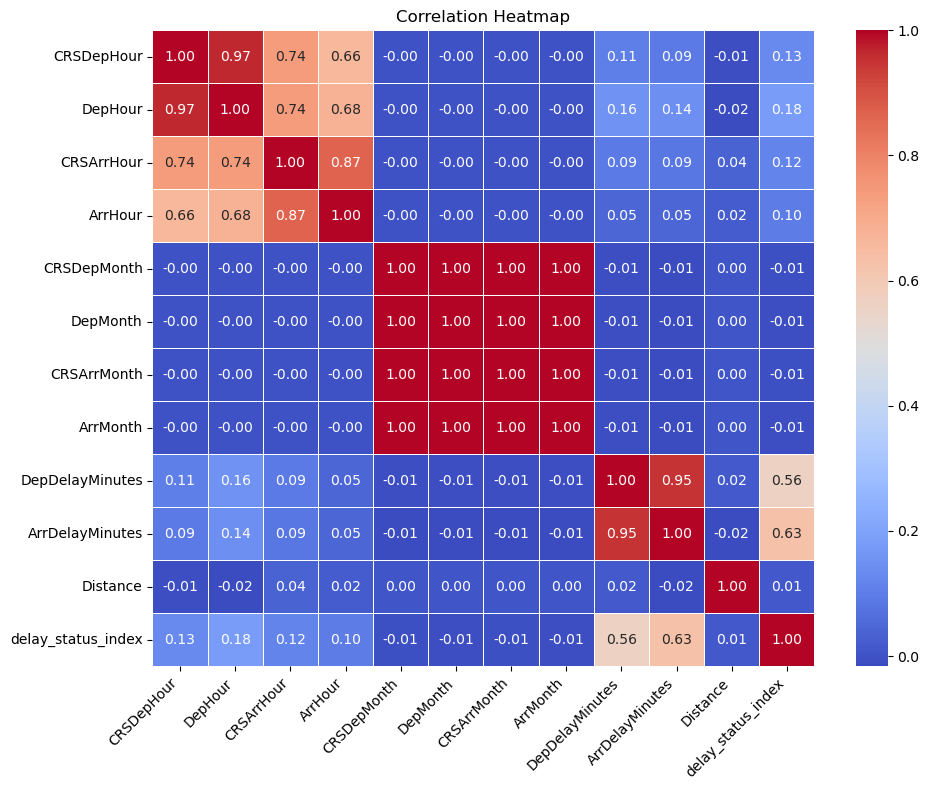

In [42]:
ordered_columns = ["CRSDepHour",
    "DepHour",
    "CRSArrHour",
    "ArrHour",
    "CRSDepMonth",
    "DepMonth",
    "CRSArrMonth",
    "ArrMonth",
    "DepDelayMinutes",
    "ArrDelayMinutes",
    "Distance",
    "delay_status_index"
]

correlation_df = pd.DataFrame(correlation_matrix, columns=columns, index=columns)
correlation_df = correlation_df.reindex(index=ordered_columns, columns=ordered_columns)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()